##Name: Bhavesh Kumar Bohara (MML2022013)

This assignment covers  using 3 Word Embeddings : Doc2Vec, GloVe and FastText
1) https://github.com/practical-nlp/practical-nlp-code/tree/master/Ch4 - Use this link for Doc2Vec and FastText
2) https://analyticsindiamag.com/hands-on-guide-to-word-embeddings-using-glove/ , https://www.projectpro.io/recipes/use-glove-embedings - Use these 2 links for GloVe (perform all tasks)

For submission upload a single google colab file with the implementation in the python notebooks and attached articles along with proper documentation and separate sections for different embeddings.


### Assignment 6

#Doc2Vec demonstration

In [ ]:
!pip install nltk==3.5
!pip install pandas==1.1.5
!pip install gensim==3.8.3
!pip install scikit-learn==0.21.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434692 sha256=7345643218d77311e550969e04b32964f81c062c608dc213fcce15ddc2968825
  Stored in directory: /root/.cache/pip/wheels/13/ae/bb/5e2a232ebaa1d2f38dd5f587e9fc4cf6ccb12758d14dac14d8
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4
ERROR: pip's dependency resolv

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.9/dist-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this 

In [ ]:
#Load the dataset and explore.
try:
    from google.colab import files
    !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/train_data.csv
    !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/test_data.csv
    !ls -lah DATAPATH
    filepath = "DATAPATH/train_data.csv"
except ModuleNotFoundError:
    filepath = "Data/Sentiment and Emotion in Text/train_data.csv"

--2023-03-30 16:34:32--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/train_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2479133 (2.4M) [text/plain]
Saving to: ‘DATAPATH/train_data.csv’

train_data.csv      100%[===================>]   2.36M  --.-KB/s    in 0.01s   

2023-03-30 16:34:32 (178 MB/s) - ‘DATAPATH/train_data.csv’ saved [2479133/2479133]

--2023-03-30 16:34:32--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/test_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserc

In [ ]:
df = pd.read_csv(filepath)
print(df.shape)
df.head()

(30000, 2)


,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
df['sentiment'].value_counts()

worry         7433
neutral       6340
sadness       4828
happiness     2986
love          2068
surprise      1613
hate          1187
fun           1088
relief        1021
empty          659
enthusiasm     522
boredom        157
anger           98
Name: sentiment, dtype: int64

In [ ]:
#Let us take the top 3 categories and leave out the rest.
shortlist = ['neutral', "happiness", "worry"]
df_subset = df[df['sentiment'].isin(shortlist)]
df_subset.shape

(16759, 2)

##Text pre-processing:

Tweets are different. Somethings to consider:

- Removing @mentions, and urls perhaps?

- using NLTK Tweet tokenizer instead of a regular one

- stopwords, numbers as usual.

In [ ]:
#strip_handles removes personal information such as twitter handles, which don't
#contribute to emotion in the tweet. preserve_case=False converts everything to lowercase.
tweeter = TweetTokenizer(strip_handles=True,preserve_case=False)
mystopwords = set(stopwords.words("english"))

#Function to tokenize tweets, remove stopwords and numbers.
#Keeping punctuations and emoticon symbols could be relevant for this task!
def preprocess_corpus(texts):
    def remove_stops_digits(tokens):
        #Nested function that removes stopwords and digits from a list of tokens
        return [token for token in tokens if token not in mystopwords and not token.isdigit()]
    #This return statement below uses the above function to process twitter tokenizer output further.
    return [remove_stops_digits(tweeter.tokenize(content)) for content in texts]

#df_subset contains only the three categories we chose.
mydata = preprocess_corpus(df_subset['content'])
mycats = df_subset['sentiment']
print(len(mydata), len(mycats))

16759 16759


In [ ]:
#Split data into train and test, following the usual process
train_data, test_data, train_cats, test_cats = train_test_split(mydata,mycats,random_state=1234)

#prepare training data in doc2vec format:
train_doc2vec = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(train_data)]
#Train a doc2vec model to learn tweet representations. Use only training data!!
model = Doc2Vec(vector_size=50, alpha=0.025, min_count=5, dm =1, epochs=100)
model.build_vocab(train_doc2vec)
model.train(train_doc2vec, total_examples=model.corpus_count, epochs=model.epochs)
model.save("d2v.model")
print("Model Saved")

Model Saved


In [ ]:
#Infer the feature representation for training and test data using the trained model
model= Doc2Vec.load("d2v.model")
#infer in multiple steps to get a stable representation.
train_vectors =  [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in train_data]
test_vectors = [model.infer_vector(list_of_tokens, steps=50) for list_of_tokens in test_data]

#Use any regular classifier like logistic regression
from sklearn.linear_model import LogisticRegression

myclass = LogisticRegression(class_weight="balanced") #because classes are not balanced.
myclass.fit(train_vectors, train_cats)

preds = myclass.predict(test_vectors)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_cats, preds))

#print(confusion_matrix(test_cats,preds))

              precision    recall  f1-score   support

   happiness       0.38      0.46      0.41       713
     neutral       0.46      0.54      0.50      1595
       worry       0.59      0.46      0.51      1882

    accuracy                           0.49      4190
   macro avg       0.48      0.48      0.48      4190
weighted avg       0.50      0.49      0.49      4190



#FastText

In [ ]:
!pip install wget==3.2
!pip install fasttext==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=90557f9556b7594658a60ac0d4f269b514bbf04118a434a3995e4d0076c2c3b0
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395600 sha256=5f2692ff4c36b8e9a4dab39b20b8fc3cc66ef37635e6a6cf2fcf017c4fc02bf7
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


In [ ]:
import os
import pandas as pd
import wget
import tarfile

In [ ]:
try :

    from google.colab import files

    # downloading the data
    !wget -P DATAPATH https://github.com/le-scientifique/torchDatasets/raw/master/dbpedia_csv.tar.gz

    # untaring the required file
    !tar -xvf DATAPATH/dbpedia_csv.tar.gz -C DATAPATH

    # sneek peek in the folder structure
    !ls -lah DATAPATH

    # specifying the data_path
    data_path = 'DATAPATH'

except ModuleNotFoundError:

    if not os.path.exists(os.getcwd()+'\\Data\\dbpedia_csv') :
        # downloading the data
        url="https://github.com/le-scientifique/torchDatasets/raw/master/dbpedia_csv.tar.gz"
        path=os.getcwd()+'\Data'
        wget.download(url,path)

        # untaring the required file
        temp=path+'\dbpedia_csv.tar.gz'
        tar = tarfile.open(temp, "r:gz")
        tar.extractall(path)
        tar.close()

    # specifying the data_path
    data_path='Data'

--2023-03-30 16:39:52--  https://github.com/le-scientifique/torchDatasets/raw/master/dbpedia_csv.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/le-scientifique/torchDatasets/master/dbpedia_csv.tar.gz [following]
--2023-03-30 16:39:52--  https://raw.githubusercontent.com/le-scientifique/torchDatasets/master/dbpedia_csv.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115 [application/octet-stream]
Saving to: ‘DATAPATH/dbpedia_csv.tar.gz’

dbpedia_csv.tar.gz  100%[===================>]     115  --.-KB/s    in 0s      

2023-03-30 16:39:52 (3.80 MB/s) - ‘DATAPATH/dbpedia_csv.tar.gz’ s

In [ ]:
# Loading train data
train_file = '/content/DATAPATH/train_data.csv'
df = pd.read_csv(train_file, header=None, names=['class','name','description'])
# Loading test data
test_file = '/content/DATAPATH/test_data.csv'
df_test = pd.read_csv(test_file, header=None, names=['class','name','description'])
# Data we have
print("Train:{} Test:{}".format(df.shape,df_test.shape))

Train:(30001, 3) Test:(10001, 3)


In [ ]:
# Since we have no clue about the classes lets build one
# Mapping from class number to class name
class_dict={
            1:'Company',
            2:'EducationalInstitution',
            3:'Artist',
            4:'Athlete',
            5:'OfficeHolder',
            6:'MeanOfTransportation',
            7:'Building',
            8:'NaturalPlace',
            9:'Village',
            10:'Animal',
            11:'Plant',
            12:'Album',
            13:'Film',
            14:'WrittenWork'
        }

# Mapping the classes
df['class_name'] = df['class'].map(class_dict)
df.head()

,class,name,description,class_name
0,sentiment,content,NaN,NaN
1,empty,@tiffanylue i know i was listenin to bad habi...,NaN,NaN
2,sadness,Layin n bed with a headache ughhhh...waitin o...,NaN,NaN
3,sadness,Funeral ceremony...gloomy friday...,NaN,NaN
4,enthusiasm,wants to hang out with friends SOON!,NaN,NaN


In [ ]:
df["class_name"].value_counts()

Series([], Name: class_name, dtype: int64)

In [ ]:
# Lets do some cleaning of this text
def clean_it(text,normalize=True):
    # Replacing possible issues with data. We can add or reduce the replacemtent in this chain
    s = str(text).replace(',',' ').replace('"','').replace('\'',' \' ').replace('.',' . ').replace('(',' ( ').\
            replace(')',' ) ').replace('!',' ! ').replace('?',' ? ').replace(':',' ').replace(';',' ').lower()

    # normalizing / encoding the text
    if normalize:
        s = s.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')

    return s

# Now lets define a small function where we can use above cleaning on datasets
def clean_df(data, cleanit= False, shuffleit=False, encodeit=False, label_prefix='__class__'):
    # Defining the new data
    df = data[['name','description']].copy(deep=True)
    df['class'] = label_prefix + data['class'].astype(str) + ' '

    # cleaning it
    if cleanit:
        df['name'] = df['name'].apply(lambda x: clean_it(x,encodeit))
        df['description'] = df['description'].apply(lambda x: clean_it(x,encodeit))

    # shuffling it
    if shuffleit:
        df.sample(frac=1).reset_index(drop=True)

    return df

In [ ]:
%%time
# Transform the datasets using the above clean functions
df_train_cleaned = clean_df(df, True, True)
df_test_cleaned = clean_df(df_test, True, True)

CPU times: user 249 ms, sys: 12.9 ms, total: 262 ms
Wall time: 284 ms


In [ ]:
# Write files to disk as fastText classifier API reads files from disk.
train_file = data_path + '/dbpedia_train.csv'
df_train_cleaned.to_csv(train_file, header=None, index=False, columns=['class','name','description'] )

test_file = data_path + '/dbpedia_test.csv'
df_test_cleaned.to_csv(test_file, header=None, index=False, columns=['class','name','description'] )

In [ ]:
%%time
## Using fastText for feature extraction and training
from fasttext import train_supervised
"""fastText expects and training file (csv), a model name as input arguments.
label_prefix refers to the prefix before label string in the dataset.
default is __label__. In our dataset, it is __class__.
There are several other parameters which can be seen in:
https://pypi.org/project/fasttext/
"""
model = train_supervised(input=train_file, label="__class__", lr=1.0, epoch=75, loss='ova', wordNgrams=2, dim=200, thread=2, verbose=100)

CPU times: user 1min 38s, sys: 1.98 s, total: 1min 40s
Wall time: 1min 12s


In [ ]:
for k in range(1,6):
    results = model.test(test_file,k=k)
    print(f"Test Samples: {results[0]} Precision@{k} : {results[1]*100:2.4f} Recall@{k} : {results[2]*100:2.4f}")

Test Samples: 0 Precision@1 : nan Recall@1 : nan
Test Samples: 0 Precision@2 : nan Recall@2 : nan
Test Samples: 0 Precision@3 : nan Recall@3 : nan
Test Samples: 0 Precision@4 : nan Recall@4 : nan
Test Samples: 0 Precision@5 : nan Recall@5 : nan


#GloVe-I

In [ ]:
import os
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE
import numpy as np

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [ ]:
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

('glove.6B.zip', <http.client.HTTPMessage at 0x7f0a01a08b50>)

In [ ]:
!unzip "/content/glove.6B.zip" -d "/content/"

Archive:  /content/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
emmbed_dict = {}
with open('/content/glove.6B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [ ]:
def find_similar_word(emmbedes):
  nearest = sorted(emmbed_dict.keys(), key=lambda word: spatial.distance.euclidean(emmbed_dict[word], emmbedes))
  return nearest

In [ ]:
find_similar_word(emmbed_dict['river'])[0:10]


['river',
 'rivers',
 'tributary',
 'confluence',
 'creek',
 'along',
 'tributaries',
 'valley',
 'flows',
 'danube']

In [ ]:
find_similar_word(emmbed_dict['king'] + emmbed_dict['queen'] + emmbed_dict['prince'])[0:10]

['king',
 'prince',
 'queen',
 'princess',
 'crown',
 'throne',
 'royal',
 'monarch',
 'kingdom',
 'duke']

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
/usr/local/lib/python3.9/dist-packages/sk

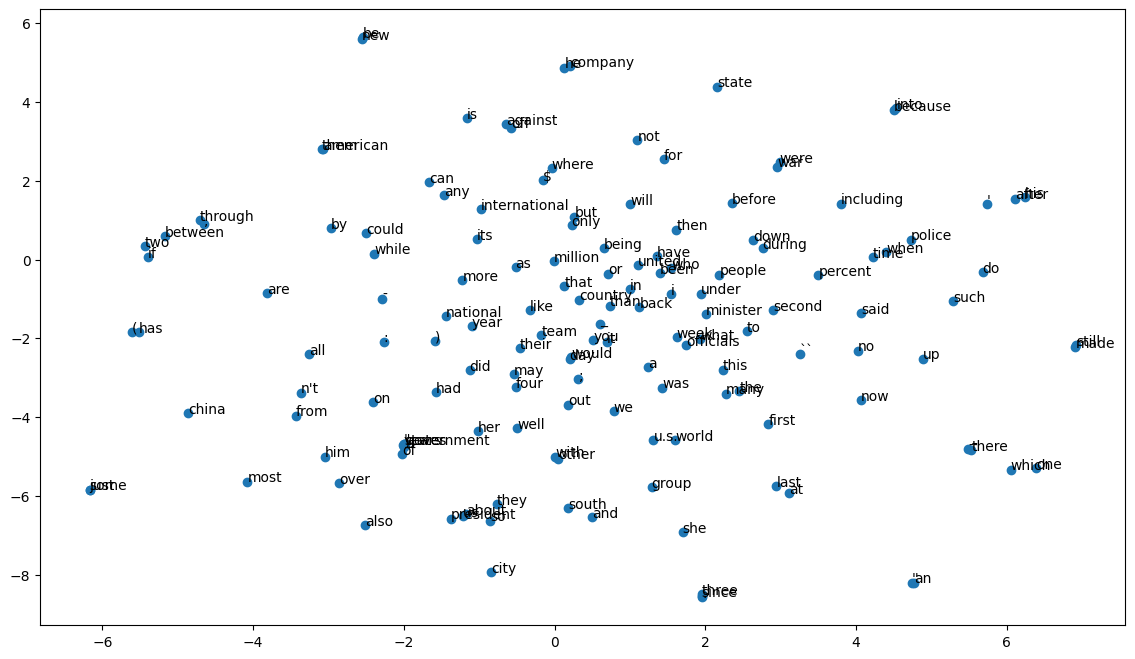

In [ ]:
import numpy as np
distri = TSNE(n_components=2)
words = list(emmbed_dict.keys())
vectors = [emmbed_dict[word] for word in words]
y = distri.fit_transform(np.array(vectors[700:850]))
plt.figure(figsize=(14,8))
plt.scatter(y[:, 0],y[:,1])
for label,x,y in zip(words,y[:, 0],y[:,1]):
  plt.annotate(label,xy=(x,y),xytext=(0,0),textcoords='offset points')
plt.show()

##GloVe-II

In [ ]:
#pip install -U mittens

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install glove_python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached glove_python-0.1.0.tar.gz (263 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for glove_python
  Running setup.py clean for glove_python
  error: subprocess-exited-with-error
  
  × python setup.py clean did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed cleaning build dir for glove_python
Failed to build glove_python
  error: subprocess-exited-with-error
  
  × Running setup.py install for glove_python did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This err

In [ ]:
!pip install glove-python-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement glove-python-binary (from versions: none)
ERROR: No matching distribution found for glove-python-binary


In [ ]:
import itertools
from gensim.models.word2vec import Text8Corpus
from glove import Corpus, Glove

ModuleNotFoundError: ignored

In [ ]:
sentences = list(itertools.islice(Text8Corpus('/content/alice_in_wonderland.txt'),None))

In [ ]:
pip install --upgrade pip && pip install lazy_module

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
corpus = corpus()

NameError: ignored

In [ ]:
corpus.fit(sentences, window=10)

In [ ]:
glove = Glove(no_components=100, learning_rate=0.05)

In [ ]:
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)

In [ ]:
glove.add_dictionary(corpus.dictionary)

In [ ]:
glove.most_similar('man')

In [ ]:
glove.most_similar('this', number=10)

In [ ]:
glove.most_similar('Adventures', number=10)

In [ ]:
glove.most_similar('girl', number=10)

In [ ]:
glove.most_similar('Alice', number=10)